<h1>EFR teleswitch</h1>


# Introduction

Info about EFR teleswith can be found here: <A HREF="https://www.sigidwiki.com/wiki/EFR_Teleswitch">sigidwiki</A><br>
<blockquote>
Europäische Funk-Rundsteuerung (EFR) Teleswitch (European Radio Ripple Control GmbH (ERA) Teleswitch) is an energy management system operated via long-wave radio. The system is deployed by European Radio Ripple Control GmbH.
Uses two transmitters in Germany and one in Hungary, covering most of Central Europe. Also known by DCF39, DCF49 and HGA22, the transmitters in the network.<br>
EFR uses FSK modulation with 340 Hz shift at 200 bps ASCII <br>
</blockquote>
<br>
Due to the low speed and simple modulation, EFR is a good candidate for a first exercise to learn signal-processing with python<br>
<br>


## Part 1: Preparations
### Loading libraries

In [1]:
import numpy as np
import scipy.signal

import matplotlib.pyplot as plt
%matplotlib inline

### Loading data
<br>
The datafile used in this exercise is a recording of the three transmitters of the EFR services, containing I/Q sample-data. The recording was done with gqrx in "raw-iq" receiver-mode, a SDRplay RSP-dx and an active miniwhip antenna. Using linux pulseaudio, the audio of gqrx was the piped into a GNU Radio flowgraph that converted the audio into a file of I/Q data in float32 format.<br>
The samplerate is 48000 samples per second.

In [6]:
samp_rate=48000.0
numsec=30 #well just oad 30 seconds of data

d=np.fromfile("efr_teleswitch_30s.f32",dtype=np.complex64,offset=0,count=int(samp_rate*numsec))


### Examining the data
Let's make a spectrogram (horizontal waterfall)<br>
<br>
We use "plt.axis.specgram" as that seems to produce a much better result then the scipy.signal.spectrogram function.

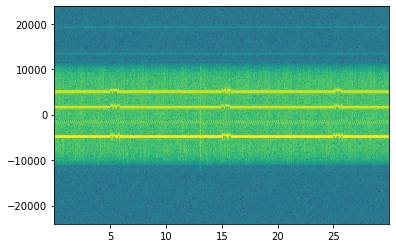

In [7]:
ax = plt.axes()
ax.specgram(d, Fs=48000, scale='dB')
plt.show()

## Part 2: Filtering out the wanted signal

Let's focus on the bottom signal (transmitter DCF49 at 139.0 KHz). Let's zoom into the spectrumgram to determine the frequency relative to 0 Hz of that signal in the I/Q-sample file.

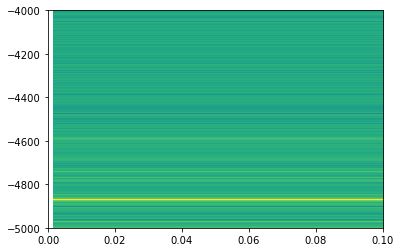

In [8]:
ax = plt.axes()
ax.specgram(d, Fs=48000, NFFT=32768,scale='dB') # note: increase the number of FFT bins to increase frequency resolution
ax.set_xlim(0,0.1)
ax.set_ylim(-5000,-4000)
plt.show()

Let's play with the "NFFT" and the "ax.set_ylim" values a bit more to get an exact as possible value of the frequency of that signal.

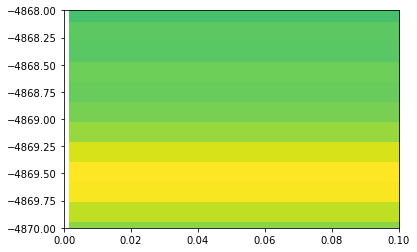

In [9]:
ax = plt.axes()
ax.specgram(d, Fs=48000, NFFT=262144,scale='dB') # note: increase the number of FFT bins to increase frequency resolution
ax.set_xlim(0,0.1)
ax.set_ylim(-4870,-4868)
plt.show()

### Automate things
OK, so the frequency seems to be around -4869.6 Hz.<br>
<br>
But that was a lot of manual work, so let's try to do this automatically.<br>
As the signal we are looking for is the strongest signal in the capture-data, we can do a FFT of the start of the I/Q data and look for the frequency-bin with the highest "real" value.

In [10]:
f=np.fft.fftshift(np.fft.fft(d,n=262144))
maxbin=np.argmax(f.real)
print("frequency:",samp_rate*(maxbin/262144)-(samp_rate/2))

frequency: -4869.68994140625


### Upconvert
Create a tone of 4669.69 Hz, mix it with the received signal to upconvert that signal to 0 Hz and let's look at the result.

In [11]:
tone_freq=-(samp_rate*(maxbin/262144)-(samp_rate/2))
tone_t=np.linspace(0,numsec*tone_freq*2*np.pi,int(numsec*samp_rate), endpoint=False)
tone_s=np.cos(tone_t)+np.sin(tone_t)*1j



In [12]:
dmixed=d*tone_s


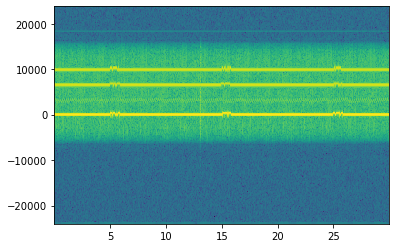

In [13]:
ax = plt.axes()
ax.specgram(dmixed, Fs=48000, scale='dB')
plt.show()



### Isolate the wanted signal
Apply a low-pass filter to the signal to remove the two other signals in the spectrum, and plot at the result.

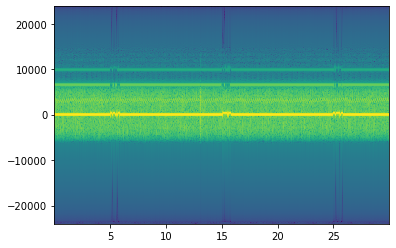

In [14]:
# filter at 0.2 * 48000 / 2
f=scipy.signal.firwin(41,0.2) # why 41 taps? No idea, it worked and gave a good result

dfiltered=np.convolve(dmixed,f)[:-40] # remove last 40 data elements so not to change length

ax = plt.axes()
ax.specgram(dfiltered, Fs=48000, scale='dB')
plt.show()


## Part 3: FM Demodulate

OK, we now have one single nice clean signal. Let's do the next step: FM demodulation.

### Downsample
First downsample the signal to a lower bitrate to make it more easy to process<br>


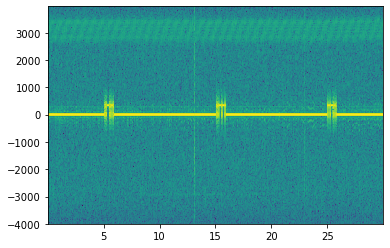

In [15]:
# downsample to lower sampling-rate (1/6: 48000 -> 8000)

ddownsamp=scipy.signal.resample_poly(dfiltered,1,6)
samp_rate_low=samp_rate / 6 # new samplerate is 8000 samples / second

# let's look at the result
ax = plt.axes()
ax.specgram(ddownsamp, Fs=8000, scale='dB')
plt.show()



Note: later I found that the function 'scipy.signal.resample_poly' actually also applies a low-pass filter before doing the resampling. So, in theory, the step of low-pass filtering done above isn't necessairy.

## FM demodulation
Quadrature demodulation: subtract the angle of the current I/Q sample from the angle of the previous I/Q sample; and apply a 'mod' operation to keep the result between between -pi and +pi radials.

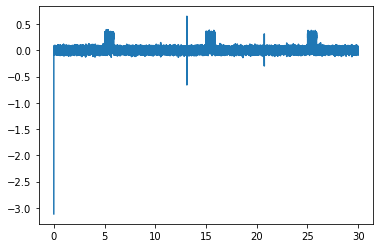

In [16]:
# fm demod
a1=np.angle(ddownsamp[1:])
a2=np.angle(ddownsamp[:-1])

pi=np.pi
pi2=np.pi*2
ad=(((a1-a2)+pi)%(pi2))-pi

t=np.linspace(0,numsec,int(numsec*samp_rate_low)-1)

# plot the result 
plt.plot(t,ad)
plt.show()



### Examining the received packet

<br>We can clearly see 3 data packets, let's zoom in to the first packet to see what it looks like. The scale on the x-axis now indicates the sample-number.

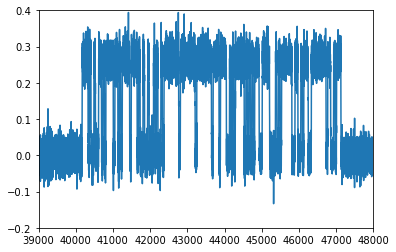

In [17]:
plt.plot(ad)
plt.xlim(39000,48000)
plt.ylim(-0.2,0.4)
plt.show()


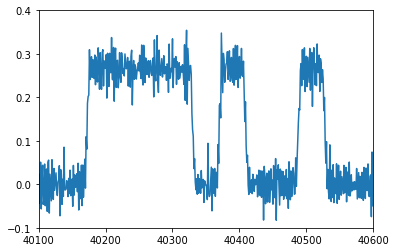

In [18]:
# zoom in even more
plt.plot(ad)
plt.xlim(40100,40600)
plt.ylim(-0.1,0.4)
plt.show()

### Cleaning up the signal
Let's create and apply a schmitt-trigger ("threshold") to normalise the values to 0 or 1. We put the upper (0-to-1) value to 0.2. The lower (1-to-0) value is set to 0.1. This is done with a python class.

In [19]:
# create the schmitt trigger

class schmitt():
    def __init__(self,lowerval,upperval,startv=0):
        self.currentv=startv
        self.upperval=upperval
        self.lowerval=lowerval

    def next(self, v):
        if self.currentv == 0:
            if v > self.upperval:
                self.currentv=1
            #end if
        else:
            if v < self.lowerval:
                self.currentv=0
            #end if
        #end else - if
        return self.currentv

    def reinit(self,startv=0):
        self.currentv=startv
		


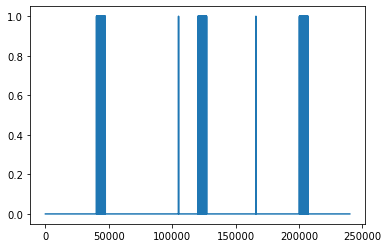

In [20]:
# apply the schitt-trigger

st=schmitt(0.1,0.2)

ad2=np.array([st.next(x) for x in ad])

# plot the results
plt.plot(ad2)
plt.show()



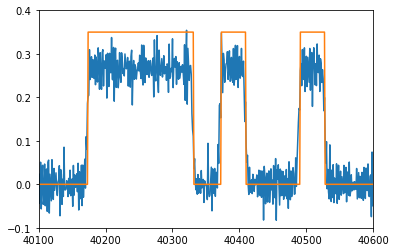

In [21]:
# zoom in
plt.plot(ad)
plt.plot(ad2 * 0.35) # scale down to 0 to 0.35 for clarity
plt.xlim(40100,40600)
plt.ylim(-0.1,0.4)
plt.show()

## Part 4: clock recovery and extracting bits

### Finding the start of the packet
Before we can do any operation on the packet, we must first determine where it starts. The trick here is to make a new numpy array with True or False values indicationg if a sample of the (normalised) demodulation signal is more then 0.5; and then use 'argmax' to find the first instance where this value is true. The argmax function returns the sample-number.<br>
<br>
(idea shamelessly stolen here)<br>
https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value

In [22]:
# find first occurence where signal is present
startpacket=np.argmax(ad2>0.5)
print("The packet starts at sample",startpacket)

The packet starts at sample 40174


### Clock recovery.
The next step is clock-recovery: determine the middle sample of every databit so we can use that particular sample to determine the value of the databit.<br>
The code below is loosly based on the polyphase clock syncronisation. This process compaires the received signal with the signal that is expected to be received -in this case, 40 consecutive "1" samples- at every possible phase (time-offset). For this, it uses comvolution. The phase that produces the maximum result of the np.convolute function is consider the best possible match.<br>
<br>
The location of this "best match" sample controls the "start-of-bit" pointer that can move forward or backwards by one sample per databit. The sample halfway the databit (i.e. 20 samples after the start-of-bit pointer) is used to determine the value of the databit.<br>
<br>
The system initialises the "start-of-bit" pointer with the start of the frame value, as calculated in the jupyter notebook cell above.

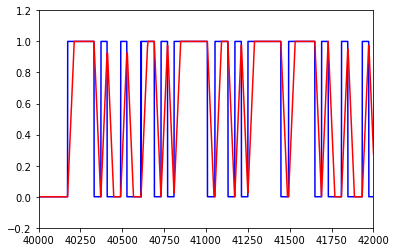

In [23]:
# samplerate = 8000 sps, baudrate = 200 -> convolute to a 40 time "1" pattern.

bit40=np.ones(40,dtype=np.float64)
ad3=np.convolve(ad2,bit40)/40

# plot the result, zooming in on the start of the frame
plt.plot(ad2, color="blue")
plt.plot(ad3, color="red")
plt.xlim(40000,42000)
plt.ylim(-0.2,1.2)
plt.show()




Note that the output of the convolution function (red line) reaches the extreme value (0.0 or 1.0) at the end every databit.<br>

### Extract bits

Next step: real all this bits of the frame. Bits are read until 10 consecutive "0"s are read.

In [25]:
# extract bits
zerosreceived=0
received=[]

p=startpacket

# read samples until we receive 10 consecutive "0" bits

while True: # endless loop
    
    # check output of convolution
	# get the last 5 samples of convolution data for this bit,
	# from end-of-packet - 2 to end-of=packet + 2
	c=ad3[p+38:p+43]

	lower=c[0]+c[1]
	mid=c[2]
	higher=c[3]+c[4]

	if (lower == higher):
		# ad3 is in balance, move up 40 samples for the next databit
		p+=40
	elif (lower > higher):
        #ad3 is out of balance, move up 39 or 41 samples
		if mid > 0.5:
			p+=39
		else:
			# mid < 0.5
			p+=41
		#end if
	else:
		# higer > lower
		if mid > 0.5:
			p+=41
		else:
			# mid < 0.5
			p+=39
		#end if
	#end if	

	# get databit value, based on the sample in the middle of the databit
	v=round(ad2[p-20]) # p has already been moved up by 39, 40 or 41 samples, so "p" is now the end of the current bit
	received.append(v)
	print("{v} {p} [{c0:1.2f},{c1:1.2f},{c2:1.2f},{c3:1.2f},{c4:1.2f}]".format(v=v,p=p,c0=c[0],c1=c[1],c2=c[2],c3=c[3],c4=c[4]))


	
	# do we need to continue?
	if v == 0:
		zerosreceived+=1
		if zerosreceived >= 10: break
	else:
		# v is 1
		zerosreceived=0
	#end if
#end for

# broken out of endless loop .. DONE

1 40215 [0.97,1.00,1.00,1.00,1.00]
1 40255 [1.00,1.00,1.00,1.00,1.00]
1 40295 [1.00,1.00,1.00,1.00,1.00]
1 40334 [0.95,0.93,0.90,0.88,0.85]
0 40373 [0.00,0.03,0.05,0.07,0.10]
1 40412 [0.93,0.93,0.90,0.88,0.85]
0 40452 [0.00,0.00,0.00,0.00,0.00]
0 40491 [0.00,0.03,0.05,0.07,0.10]
1 40530 [0.93,0.93,0.90,0.88,0.85]
0 40570 [0.00,0.00,0.00,0.00,0.00]
0 40609 [0.00,0.00,0.00,0.00,0.03]
1 40650 [0.88,0.90,0.93,0.95,0.97]
1 40689 [1.00,1.00,1.00,1.00,0.97]
0 40730 [0.10,0.07,0.05,0.03,0.00]
1 40771 [0.93,0.95,0.97,0.97,0.95]
0 40810 [0.03,0.03,0.05,0.07,0.10]
1 40851 [0.97,1.00,1.00,1.00,1.00]
1 40891 [1.00,1.00,1.00,1.00,1.00]
1 40931 [1.00,1.00,1.00,1.00,1.00]
1 40971 [1.00,1.00,1.00,1.00,1.00]
1 41010 [0.97,0.95,0.93,0.90,0.88]
0 41050 [0.00,0.00,0.00,0.00,0.00]
1 41091 [0.88,0.90,0.93,0.95,0.97]
1 41130 [1.00,1.00,1.00,0.97,0.95]
0 41171 [0.07,0.05,0.03,0.00,0.00]
1 41212 [0.93,0.95,0.97,0.97,0.95]
0 41251 [0.03,0.03,0.05,0.07,0.10]
1 41292 [0.97,1.00,1.00,1.00,1.00]
1 41332 [1.00,1.00,1

## Extracting the message

The format of a EFR telegram is described in this document:<br>
http://k183.bake-neko.net/ji3bnb/pdf/teleswitch_document_004.pdf<br>
<br>
TLDR information:<br>
- a telegram consists of words of 11 bits (not 9, as one would conclude from the document above): a '1', an even-parity bit, 8 databits and a '0'
- the bits are transmitted in reverse bitorder
- A frequencies of the FSK mark and space frequencies are inverted. (so the highest FSK frequency is a '0', not a '1').

In [26]:
numbits=int(np.floor(len(received)/11)*11)

for p in range(0,numbits,11):
    # per 11 bits
    b=np.array(received[p:p+11], dtype=np.int32)

    b2=(1-b)  # invert bits, FSK Mark/Space frequency correction
	
    b3=np.flip(b2) # invert bit-order
    
    # print bit 0 ('1' : startbit?), 1 (even-parity), 2-9 (data bits), 10 ('0': stopbit?)
    print(b3[0],b3[1],b3[2:10],b3[10])
#end for



1 1 [0 1 1 0 1 0 0 0] 0
1 0 [0 0 0 0 1 0 1 0] 0
1 0 [0 0 0 0 1 0 1 0] 0
1 1 [0 1 1 0 1 0 0 0] 0
1 0 [1 1 0 1 0 1 1 1] 0
1 0 [0 0 0 0 0 0 0 0] 0
1 0 [0 0 0 0 0 0 0 0] 0
1 0 [0 0 0 0 0 0 0 0] 0
1 1 [0 0 0 0 1 0 0 0] 0
1 0 [0 0 0 0 0 1 0 1] 0
1 1 [0 0 0 1 0 1 0 1] 0
1 0 [1 1 1 1 0 0 0 0] 0
1 1 [0 0 0 0 0 0 0 1] 0
1 1 [0 0 0 1 0 1 1 0] 0
1 0 [0 0 0 0 0 0 0 0] 0
1 1 [0 0 0 1 0 1 1 0] 0
